In [1]:
from robust import student_t_GP as TGaussianProcess
import celerite2
import matplotlib.pyplot as plt

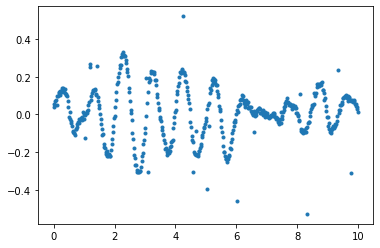

In [22]:
rho, tau, sigma, diag, mean = [1, 2, 0.1, 1e-4, 0.0]
t = np.linspace(0, 10, 500)
k = celerite2.terms.SHOTerm(
            rho=rho, 
            tau=tau, 
            sigma=sigma
        )

gp = celerite2.GaussianProcess(k)
gp.compute(t, diag=0.0)

y_true = gp.sample()
y = y_true + np.random.randn(len(t)) * np.sqrt(diag)
gp.compute(t, diag=diag)

n_out = 20
inds = np.random.randint(len(t), size=n_out)
#inds = np.random.randint(len(t)//10, size=n_out) + 200

y[inds] += np.random.randn(n_out) * 0.3
plt.plot(t, y, '.')

In [23]:
from scipy.optimize import minimize

def nll_t(p, y):
    
    rho, tau, sigma, diag = np.exp(p[:-1])
    mean = p[-1]
    
    k = celerite2.terms.SHOTerm(
            rho=rho, 
            tau=tau, 
            sigma=sigma
    )
    tgp = TGaussianProcess(k)
    tgp.compute(t, diag=diag)
    return - tgp.log_likelihood(y - mean)

def nll(p, y):
    
    rho, tau, sigma, diag = np.exp(p[:-1])
    mean = p[-1]
    
    if np.any([rho, tau, sigma, diag]) < 0.0:
        return np.inf
    
    k = celerite2.terms.SHOTerm(
            rho=rho, 
            tau=tau, 
            sigma=sigma
    )
    gp = celerite2.GaussianProcess(k)
    gp.compute(t, diag=diag)
    return - gp.log_likelihood(y - mean)

p = list(np.log([2, 1, 0.01, 1e-5])) + [0.0]
best_fit_tgp = minimize(nll_t, p, args=(y,), method='BFGS').x
best_fit_gp = minimize(nll, p, args=(y,), method='BFGS').x

print(best_fit_tgp)
print(best_fit_gp)

[-2.34644033e-02  9.23259160e-01 -2.13930347e+00 -5.91495810e+00
  4.05927313e-03]
[ 2.65833965e+00 -4.70186811e+01 -2.38254312e+01 -3.96169850e+00
  5.93268568e-03]


CPU times: user 42.6 ms, sys: 3.91 ms, total: 46.5 ms
Wall time: 49.1 ms


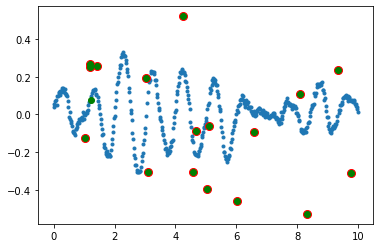

In [24]:
from robust import bic, aic

p = best_fit_tgp
rho, tau, sigma, diag = np.exp(p[:-1])
mean = p[-1]
k = celerite2.terms.SHOTerm(
            rho=rho, 
            tau=tau, 
            sigma=sigma
)
tgp = TGaussianProcess(k)
tgp.compute(t, diag=diag)
%time b, bias = bic(tgp, y, return_bias=True)
a = aic(tgp, y)

cutoff = 0

plt.plot(t, y, '.')
plt.plot(t[b < cutoff], y[b < cutoff], 'ro', markersize=8)
plt.plot(t[a < cutoff], y[a < cutoff], 'go', markersize=6)

In [25]:
from robust import biased_GP

x = [x if b < cutoff else 0.0 for x, b in zip(bias, b)]
bgp = biased_GP(k, bias=x)
bgp.compute(t, diag=diag)

In [26]:
def nll_bias(p, y, inds):
    
    rho, tau, sigma, diag = np.exp(p[:4])
    mean = p[4]
    x = p[5:]
    bias = np.zeros_like(y)
    bias[inds] = x
    
    k = celerite2.terms.SHOTerm(
            rho=rho, 
            tau=tau, 
            sigma=sigma
    )
    bgp = biased_GP(k, bias=bias)
    bgp.compute(t, diag=diag)
    return - bgp.log_likelihood(y - mean)

p = list(np.log([2, 1, 0.01, 1e-5])) + [0.0] + list(bias[b < cutoff])
best_fit_bias = minimize(nll_bias, p, args=(y, np.where(b < cutoff)[0])).x
print(best_fit_bias)

x = np.zeros_like(y)
x[np.where(b < cutoff)[0]] = best_fit_bias[5:]
bgp = biased_GP(k, bias=x)
bgp.compute(t, diag=diag)

[-2.93258166e-02  8.65188127e-01 -2.14301274e+00 -9.19342873e+00
  5.80591004e-03  1.28988983e-01 -2.02071745e-01 -1.75865425e-01
 -1.58428366e-01 -1.72456993e-01  4.01738682e-01 -2.87671688e-01
  1.27244422e-01 -1.32241299e-01  4.04985456e-01  1.52598093e-01
  4.66028340e-01  9.30161332e-02 -1.68553374e-01  4.56170292e-01
 -2.40210321e-01  3.85724525e-01]


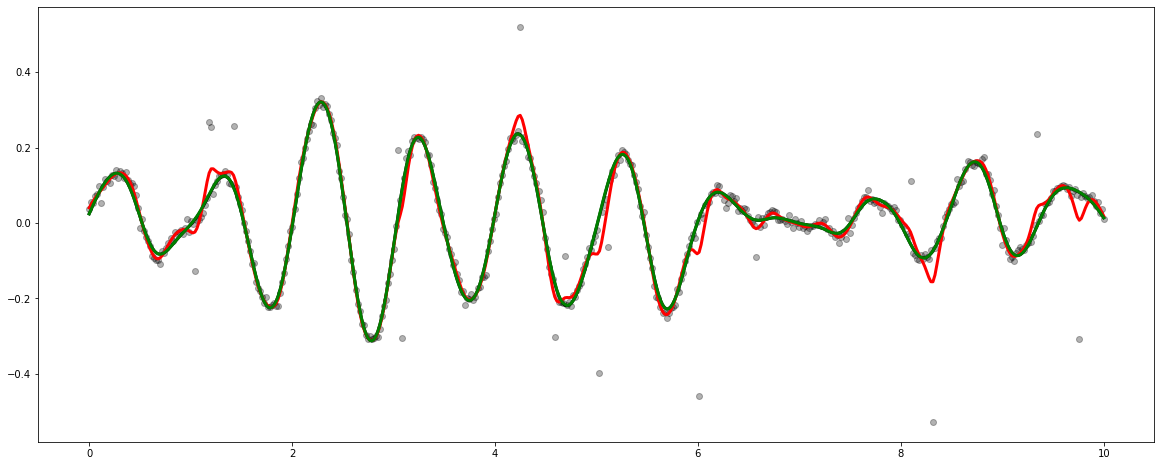

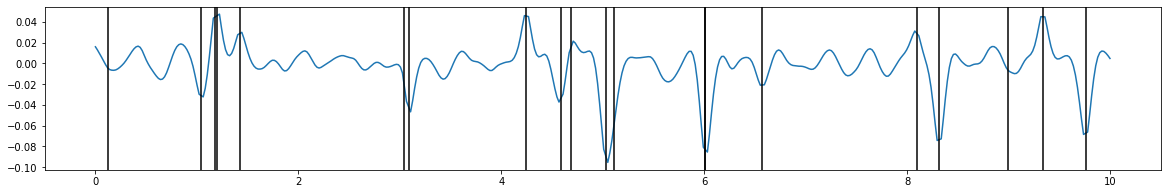

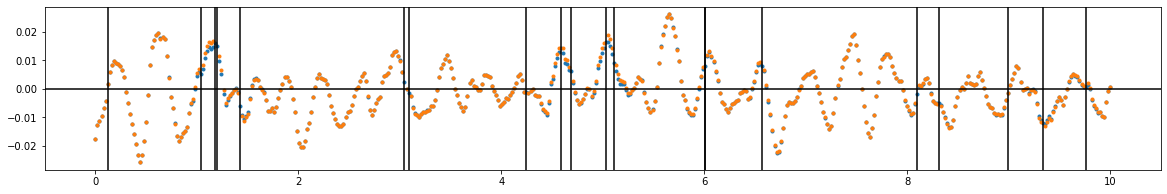

In [27]:
y_bias = bgp.predict(y)
y_nobias = gp.predict(y)

newgp = celerite2.GaussianProcess(k)
newgp.compute(t[b > cutoff], diag=diag)
y_no_outliers = newgp.predict(y[b > cutoff])

plt.figure(figsize=(20, 8))
plt.plot(t, y, 'ko', alpha=0.3)
plt.plot(t, y_bias, 'k', linewidth=3)
plt.plot(t, y_nobias, 'r', linewidth=3)
plt.plot(t[b > cutoff], y_no_outliers, 'g', linewidth=3)

plt.figure(figsize=(20, 3))
plt.plot(t[b > cutoff], y_nobias[b > cutoff] - y_no_outliers)
[plt.axvline(t[inds], color='k') for inds in inds];

plt.figure(figsize=(20, 3))
plt.plot(t, y_bias - y_true, '.')
plt.plot(t[b > cutoff], y_no_outliers - y_true[b > cutoff], '.')
[plt.axvline(t[inds], color='k') for inds in inds];
plt.axhline(0.0, color='k')